# Задание
- Применить метод К ближащих соседей (ядерный) с алгоритмом STOLP для 5 классов сгенерированных с помошью make_classification
- Для сгенерированного датасета построить профиль компактности
- Для сгенерированного датасета произвести оптимизацию выбора ширены окна
- Найти сет с картинками, метод/библиотеку построения эмбединга картинок (векторизация), применить KNN для векторизованных картинок
- *На своих фотках проверить обученный KNN

In [4]:
import os
# import timm
import math

# import optuna

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

In [6]:
Сoordinates, Lable = make_classification(n_samples=1200, n_features=3, 
                           n_informative=3, n_classes=5, 
                           n_redundant=0,
                           n_clusters_per_class=1,
                           random_state=20)

Сoordinates_train, Сoordinates_test, Lable_train, Lable_test = train_test_split(Сoordinates, Lable, 
                                                    test_size=400, 
                                                    random_state=0)


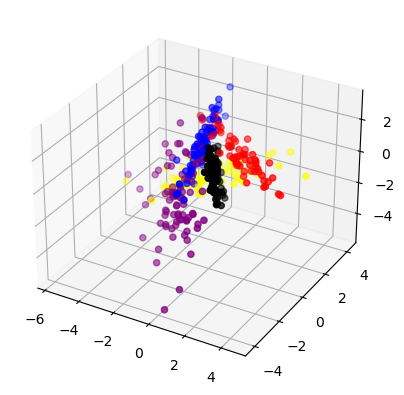

In [3]:
N = 400
colors = ["Blue","Red","Purple","Yellow","Black"]
c = [colors[i] for i in Lable_train[:N]]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Сoordinates_train[:N,0], Сoordinates_train[:N,1], Сoordinates_train[:N,2], c=c)
plt.show()

In [92]:
def Logist(r): # логистическое ядро
    return (1/(2+np.exp(r)+np.exp(-r)))

In [6]:
gen_X,gen_Y=make_classification(n_samples=1200, n_features=3, 
                           n_informative=3, n_classes=5, 
                           n_redundant=0,
                           n_clusters_per_class=1,
                           random_state=20)


In [7]:
knn=KNeighborsRegressor(n_neighbors=6,weights=Logist)
knn.fit(Сoordinates_train, Lable_train)

KNeighborsRegressor(n_neighbors=6,
                    weights=<function Logist at 0x000002B272D3B0D0>)

In [372]:
Y_noise=[Lable_train[0]]
Y_noise=np.append(Y_noise,[Lable_train[1]],axis=0)
Y_noise=np.append(Y_noise,[Lable_train[5]],axis=0)
Y_noise=np.append(Y_noise,[Lable_train[5]],axis=0)
Y_noise
X_etalon=[Сoordinates_test[0]]
X_etalon=np.append(X_etalon,[Сoordinates_test[5]],axis=0)
X_noise=[Сoordinates_test[0]]
X_noise=np.append(X_noise,[Сoordinates_test[0]],axis=0)
X_noise=np.append(X_noise,[Сoordinates_test[2]],axis=0)
X_noise=np.append(X_noise,[Сoordinates_test[1]],axis=0)
X_noise

array([[-1.63028196,  3.0879435 ,  1.10165691],
       [-1.63028196,  3.0879435 ,  1.10165691],
       [ 1.09756496,  0.74328162,  0.90016488],
       [-0.67373934,  2.00616373, -0.8397328 ]])

In [51]:
def WOkn(kor,X,Y,Ymax):
    
    return 0.1

In [181]:
import copy

In [ ]:
def Stopl(X_train,Y_train,k,lo,sigm=0,alg_clas=KNeighborsRegressor,W=WOkn):
    knn=alg_clas(n_neighbors=k,weights=Gaus)
    knn.fit(X_train, Y_train)
    X_noise=None
    X_etalon=np.zeros(((max(Y_train)+1), 3))
    clas_min_Risk=np.zeros(max(Y_train)+1)    
    np.insert(clas_min_Risk, 2 ,[sigm for i in range(len(clas_min_Risk))], axis= 1 )[:,[0,1,2]]
    X_isp=copy.deapcopy(X_train)
    Y_isp=copy.deapcopy(Y_train)
    for i in range(len(X_train)):
        Wi=W(knn,X_train[i],Y_train[i],max(Y_train))
        if Wi<=sigm:
            if clas_min_Risk[Y_train[i]] > Wi:
                X_etalon[Y_train[i]]=X_train[i]
                clas_min_Risk[Y_train[i]]=Wi
        elif X_noise ==None:
            X_isp=np.delete(X_isp,(i), axis = 0)
            Y_isp=np.delete(Y_isp,(i), axis = 0)
            X_noise=[X_train[i]]
            Y_noise=[Y_train[i]]
        else:
            X_isp=np.delete(X_isp,(i), axis = 0)
            Y_isp=np.delete(Y_isp,(i), axis = 0)
            X_noise=np.append(X_noise,[X_train[i]],axis=0)
            Y_noise=np.append(Y_noise,[Y_train[i]],axis=0)
    # удаляем из X_isp эталоны
    for  i in range(len(X_etalon)):
        Y_isp = Y_isp[np.min(X_isp[:] != X_etalon[i],axis=1)]
        X_isp = X_isp[np.min(X_isp[:] != X_etalon[i],axis=1)]
    Y_etalon=np.array([i for i in range(len(ae))])
    while 1:
        knn=KNeighborsRegressor(n_neighbors=k,weights=Logist)
        knn.fit(X_etalon, Y_etalon)
        if knn.score(X_isp,Y_isp)<lo:
            break
        for i in range(len(X_isp)):
            Wi=W(knn,X_isp[i],Y_isp[i],max(Y_train))
            if knn.predict([X_isp[i]]) !=Y_isp[i]:
                # для каждого класса находим максимум разобщёности
            
    return X_etalon ,Y_etalon ,X_noise, Y_noise


In [379]:
if knn.predict([Сoordinates_test[0]])==Lable_test[0]:
    print(1)


1


In [43]:
c=knn.kneighbors_graph(Сoordinates_test[0:1])
print(type(c))

<class 'scipy.sparse._csr.csr_matrix'>


In [23]:
Logist(a[0])

array([0.2463664 , 0.24090586, 0.23457535, 0.22927305, 0.22731209,
       0.22520332])

In [17]:
print(knn.kneighbors_graph(Сoordinates_test[0:1]),knn.kneighbors(Сoordinates_test[0:1]))

  (0, 391)	1.0
  (0, 204)	1.0
  (0, 720)	1.0
  (0, 501)	1.0
  (0, 222)	1.0
  (0, 579)	1.0 (array([[0.24229579, 0.3861818 , 0.50739673, 0.59263085, 0.62178793,
        0.65203816]]), array([[391, 204, 720, 501, 222, 579]], dtype=int64))


In [55]:
neigh_dist, neigh_ind = knn.kneighbors(Сoordinates_test[0:1])

# weights = _get_weights(neigh_dist, knn.weights)

In [56]:
neigh_dist

array([[0.24229579, 0.3861818 , 0.50739673, 0.59263085, 0.62178793]])

In [57]:
neigh_ind

array([[391, 204, 720, 501, 222]], dtype=int64)

In [53]:
knn.predict(Сoordinates_test[0:1])

array([0.])

In [13]:
# Run many combinations in a grid search manner
# To start out, you need to heuristically define your bounds.
results = [] # we will store our results here.
for k in range(1, 4): # maximum neighbor is 9 since 9:1 train split
    # you can create your own list
    # for w in np.array([0.1, 0.5, 1, 10, 100])
    for w in np.random.randint(5, 100000, 100)/1000:
        
        temp_mae = [] # temporary storage for mean absolute error
        
        # Set kernel_width = w
        def gaussian_kernel(distances):
            kernel_width = w
            weights = np.exp(-(distances**2)/(kernel_width))
            return weights
        
        # We take average of ten bootstrapped model.
        for i in range(0,100):
            # Below is my personal way of setting random state. This makes each run a bootstrapped model.
            X_train, X_test, y_train, y_test = train_test_split(gen_X,
                                                                gen_Y,
                                                                test_size=0.1,
                                                                random_state=int(100*np.random.random()))
            knn = KNeighborsRegressor(n_neighbors=k,weights=gaussian_kernel)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            mean_absolute_error = np.mean(abs(y_pred-y_test))
            temp_mae.append(mean_absolute_error)
        average_over_ten_runs = np.mean(temp_mae)
        results.append([k, w, average_over_ten_runs]) # We store our run result.
        



In [15]:
30**(1/2)

5.477225575051661